In [18]:
import numpy as np
from evol import Population, Evolution
import attr
from itertools import product
import random
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
@attr.s(kw_only=True)
class Motor:
    type_: str = attr.ib()
    power: int = attr.ib()
    valid_motor_types = ["step", "servo"]
    valid_power_values = [5, 9, 12, 24]

    @type_.validator
    def valid_motor_type(self, attribute, value):
        if value not in self.valid_motor_types:
            raise ValueError(
                f"`{value}` is an invalid motor type. Valid motor types are {self.valid_motor_types}"
            )

    @power.validator
    def valid_power(self, attribute, value):
        if value not in self.valid_power_values:
            raise ValueError(
                f"`{value}` is an invalid power value. Valid power values are {self.valid_power_values}"
            )

    @property
    def possible_motors(self):
        return list(product(self.valid_motor_types, self.valid_power_values))

    @property
    def weight(self):
        # TODO: improve the association between types and weights
        weights = dict(zip(self.valid_motor_types, [240, 63]))
        return weights[self.type_]

    def as_binary(self):
        # Width is set to 3 because a motor is encoded in 3 bits
        return np.binary_repr(self.possible_motors.index((self.type_, self.power)), 3)

    @classmethod
    def from_binary(cls, motor):
        # TODO: currently a hack, check how to access property from classmethod
        possible_motors = list(product(cls.valid_motor_types, cls.valid_power_values))
        possible_motor_index = int(motor, 2)
        motor = possible_motors[possible_motor_index]
        type_, power = motor
        return cls(type_=type_, power=power)

In [3]:
@attr.s(kw_only=True)
class PowerSource:
    type_: str = attr.ib()
    power: int = attr.ib()
    valid_power_source_types = [
        "nickel_cadmium",
        "lithium_ion",
        "solar_panel",
        "fusion_reactor",
    ]
    valid_power_values = [12, 24]

    @type_.validator
    def valid_power_source_type(self, attribute, value):
        if value not in self.valid_power_source_types:
            raise ValueError(
                f"`{value}` is an invalid power source type. Valid power source types are {self.valid_power_source_types}"
            )

    @power.validator
    def valid_power(self, attribute, value):
        if value not in self.valid_power_values:
            raise ValueError(
                f"`{value}` is an invalid power value. Valid power values are {self.valid_power_values}"
            )

    @property
    def weight(self):
        weights = dict(zip(self.valid_power_source_types, [1, 2, 3, 4]))
        return weights[self.type_]

    @property
    def possible_power_sources(self):
        return list(product(self.valid_power_source_types, self.valid_power_values))

    def as_binary(self):
        # Width is set to 3 because a motor is encoded in 3 bits
        return np.binary_repr(
            self.possible_power_sources.index((self.type_, self.power)), 3
        )

    @classmethod
    def from_binary(cls, motor):
        # TODO: currently a hack, check how to access property from classmethod
        possible_power_sources = list(
            product(cls.valid_power_source_types, cls.valid_power_values)
        )
        possible_power_source_index = int(motor, 2)
        power_source = possible_power_sources[possible_power_source_index]
        type_, power = power_source
        return cls(type_=type_, power=power)

In [4]:
@attr.s(kw_only=True)
class Robot:
    motor = attr.ib()
    power_source = attr.ib()

    @property
    def weight(self):
        return self.motor.weight + self.power_source.weight

    @property
    def specific_power(self):
        """range is defined as the distance the robot can travel given its weight and power source capacity.

        Returns:
            float -- the ratio of the robot's power source capacity and its total weight
        """
        # https://en.wikipedia.org/wiki/Power-to-weight_ratio#Power-to-weight_(specific_power)
        return self.power_source.power / self.weight

    def as_binary(self):
        return f"{self.motor.as_binary()}{self.power_source.as_binary()}"

    @classmethod
    def from_binary(cls, robot):
        motor = robot[:3]
        power_source = robot[3:]
        return cls(
            motor=Motor.from_binary(motor),
            power_source=PowerSource.from_binary(power_source),
        )

In [5]:
def fitness(individual):
    return (
        individual.specific_power * 10 ** 3
        - individual.weight
        - (individual.motor.power - individual.power_source.power) ** 2
    )

In [6]:
def random_robot():
    # Choose two integers between 0 and 7 then generate a power source
    # and a motor from them
    motor = Motor.from_binary(np.binary_repr(np.random.randint(0, 8)))
    power_source = PowerSource.from_binary(np.binary_repr(np.random.randint(0, 8)))
    return Robot(power_source=power_source, motor=motor)

In [7]:
def pick_random_parents(pop):
    """
    This is how we are going to select parents from the population
    """
    mom = random.choice(pop)
    dad = random.choice(pop)
    return mom, dad

In [8]:
def make_child(mom, dad):
    """
    This function describes how two candidates combine into a
    new candidate. Note that the output is a tuple, just like
    the output of `random_start`. We leave it to the developer
    to ensure that chromosomes are of the same type.
    """
    # TODO: add breed method
    mom_binary = mom.as_binary()
    dad_binary = dad.as_binary()
    index = np.random.randint(0, 7)
    child_binary = f"{mom_binary[:index]}{dad_binary[index:]}"
    return Robot.from_binary(child_binary)

In [9]:
def mutate(chromosome, sigma):
    """
    Toggle two bits at random
    """
    binary_as_list = list(chromosome.as_binary())
    bit_1 = np.random.randint(0, 6)
    bit_2 = np.random.randint(0, 6)
    binary_as_list[bit_1] = str(1 - int(binary_as_list[bit_1]))
    binary_as_list[bit_2] = str(1 - int(binary_as_list[bit_2]))
    return Robot.from_binary("".join(binary_as_list))

In [10]:
class MyLogger:
    def __init__(self):
        self.iteration = 0
        self.individuals_by_generation = []

    def log(self, pop):
        self.iteration += 1
        for i in pop.evaluate():
            individual_motor = i.chromosome.motor
            individual_power_source = i.chromosome.power_source
            individual_fitness = i.fitness
            self.individuals_by_generation.append({"generation": self.iteration, "individual_motor": individual_motor,
                                                  "individual_power_source": individual_power_source, "individual_fitness": individual_fitness})

In [11]:
logger = MyLogger()
pop = Population(
    chromosomes=[random_robot() for _ in range(10)],
    eval_function=fitness,
    maximize=True,
)
evo1 = (
    Evolution()
    .survive(n=2)
    .breed(parent_picker=pick_random_parents, combiner=make_child)
    .mutate(mutate_function=mutate, sigma=1)
    .evaluate()
    .callback(logger.log)
    .callback(logger.log)
)

In [12]:
pop.evolve(evo1, n=20)

<Population with size 10 at 2576271517176>

In [13]:
df = pd.DataFrame(logger.individuals_by_generation)

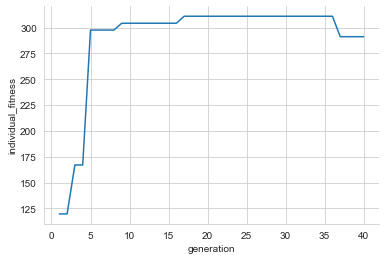

In [20]:
sns.lineplot(x="generation", y="individual_fitness", data=df.groupby("generation").agg(max).reset_index())
sns.despine()